In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

from keras.optimizers import Adam
import keras.backend as K


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../data')

# train_df = shuffle(train_df)
# valid_df = shuffle(valid_df)

print(train_df.head())


                                             image                   id  \
0  ../data/Train/CameraRGB/episode_0002_000287.png  episode_0002_000287   
1  ../data/Train/CameraRGB/episode_0008_000112.png  episode_0008_000112   
2                  ../data/Train/CameraRGB/804.png                  804   
3  ../data/Train/CameraRGB/episode_0008_000286.png  episode_0008_000286   
4  ../data/Train/CameraRGB/episode_0003_000261.png  episode_0003_000261   

                                             label  
0  ../data/Train/CameraSeg/episode_0002_000287.png  
1  ../data/Train/CameraSeg/episode_0008_000112.png  
2                  ../data/Train/CameraSeg/804.png  
3  ../data/Train/CameraSeg/episode_0008_000286.png  
4  ../data/Train/CameraSeg/episode_0003_000261.png  


In [4]:
from models.fcn8 import model_fcn8
from models.segnet import model_segnet
from models.unet import model_unetVGG16


model = model_unetVGG16()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 416, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 416, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 416, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 208, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [5]:
from gen.generators import gen_func, preprocess_label
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

rgb_gen = ImageDataGenerator(preprocessing_function=preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function = preprocess_label, **img_gen_args)

rgb_gen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
lab_gen2 = ImageDataGenerator(preprocessing_function = preprocess_label)

BATCH_SIZE=16

train_gen = gen_func(train_df, rgb_gen, lab_gen, image_size=(600, 800), target_size=(320, 416), batch_size = BATCH_SIZE)
valid_gen = gen_func(valid_df, rgb_gen2, lab_gen2, image_size=(600, 800), target_size=(320, 416), batch_size = BATCH_SIZE)
# test_and_lab_gen = gen_func(test_df, rgb_gen2, lab_gen2, image_size=(600, 800),  target_size=(480, 416), batch_size = BATCH_SIZE)

In [6]:
from train import jaccard_distance_loss
from keras.optimizers import SGD, rmsprop
from keras_contrib.losses import jaccard_distance

# opt =SGD(lr=1, momentum=0.01, decay=0.001, nesterov=False)
# opt = rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss=jaccard_distance,
              optimizer='adam',
              metrics=['accuracy', 'mse'])

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4822 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4822 images


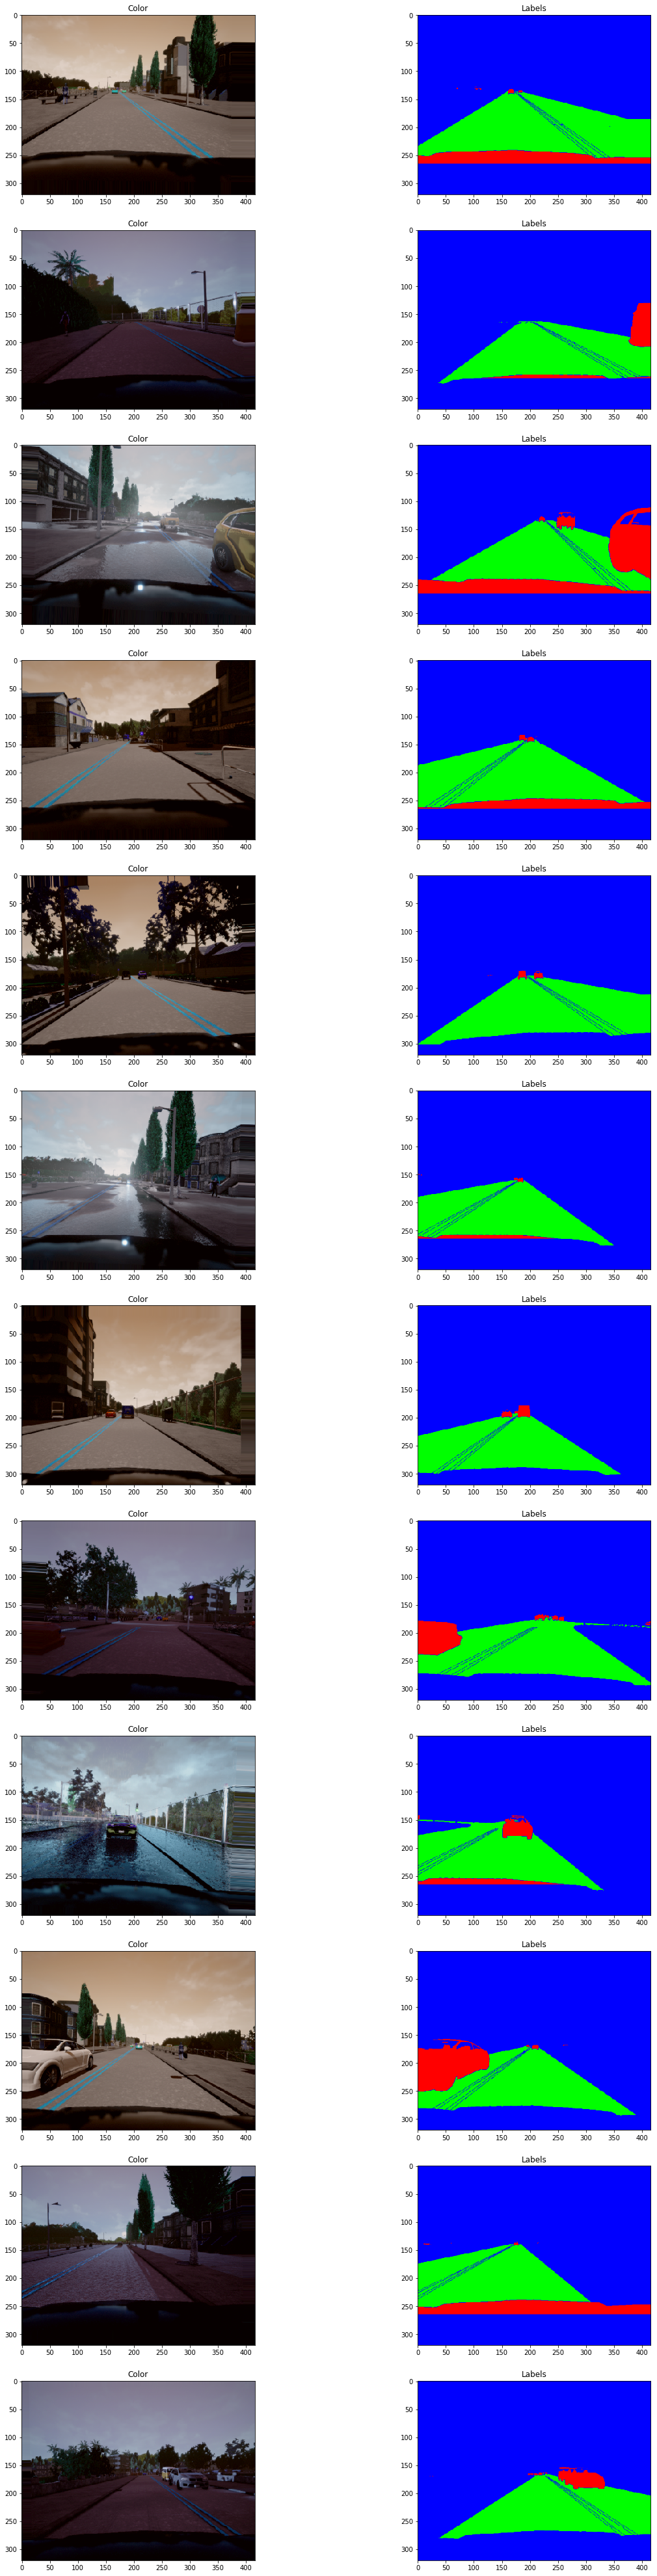

In [7]:
train_x, train_y = next(train_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, train_x, train_y):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')

In [8]:
X = np.expand_dims(train_x[2], 0)
Y = np.expand_dims(train_y[2], 0)
print (X.shape, Y.shape)

# model.reset_states()
history = model.fit(X, Y, epochs=300)

(1, 320, 416, 3) (1, 320, 416, 3)
Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 1.2944 - acc: 0.3485 - mean_squared_error: 0.2235
Epoch 2/300
1/1 [==============================] - 0s 34ms/step - loss: 1.2055 - acc: 0.4891 - mean_squared_error: 0.1983
Epoch 3/300
1/1 [==============================] - 0s 32ms/step - loss: 0.8668 - acc: 0.5762 - mean_squared_error: 0.2002
Epoch 4/300
1/1 [==============================] - 0s 32ms/step - loss: 0.5921 - acc: 0.6965 - mean_squared_error: 0.1963
Epoch 5/300
1/1 [==============================] - 0s 32ms/step - loss: 0.5866 - acc: 0.6989 - mean_squared_error: 0.1963
Epoch 6/300
1/1 [==============================] - 0s 31ms/step - loss: 0.5821 - acc: 0.6995 - mean_squared_error: 0.1935
Epoch 7/300
1/1 [==============================] - 0s 32ms/step - loss: 0.5615 - acc: 0.7025 - mean_squared_error: 0.1796
Epoch 8/300
1/1 [==============================] - 0s 31ms/step - loss: 0.5201 - acc: 0.7248 - mean_squared_error:

Epoch 68/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0388 - acc: 0.9799 - mean_squared_error: 0.0103
Epoch 69/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0412 - acc: 0.9786 - mean_squared_error: 0.0111
Epoch 70/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0376 - acc: 0.9807 - mean_squared_error: 0.0100
Epoch 71/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0386 - acc: 0.9803 - mean_squared_error: 0.0104
Epoch 72/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0397 - acc: 0.9799 - mean_squared_error: 0.0107
Epoch 73/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0386 - acc: 0.9805 - mean_squared_error: 0.0103
Epoch 74/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0376 - acc: 0.9815 - mean_squared_error: 0.0100
Epoch 75/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0368 - acc: 0.9819 - mean_squared_error: 0.0098
Epoch 76/300
1/1

Epoch 135/300
1/1 [==============================] - 0s 32ms/step - loss: 0.0320 - acc: 0.9840 - mean_squared_error: 0.0083
Epoch 136/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0316 - acc: 0.9842 - mean_squared_error: 0.0082
Epoch 137/300
1/1 [==============================] - 0s 32ms/step - loss: 0.0320 - acc: 0.9839 - mean_squared_error: 0.0083
Epoch 138/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0314 - acc: 0.9844 - mean_squared_error: 0.0081
Epoch 139/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0318 - acc: 0.9840 - mean_squared_error: 0.0082
Epoch 140/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0314 - acc: 0.9844 - mean_squared_error: 0.0081
Epoch 141/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0317 - acc: 0.9841 - mean_squared_error: 0.0082
Epoch 142/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0314 - acc: 0.9843 - mean_squared_error: 0.0081
Epoch 14

1/1 [==============================] - 0s 31ms/step - loss: 0.0297 - acc: 0.9852 - mean_squared_error: 0.0076
Epoch 202/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0296 - acc: 0.9852 - mean_squared_error: 0.0075
Epoch 203/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0294 - acc: 0.9854 - mean_squared_error: 0.0075
Epoch 204/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0296 - acc: 0.9852 - mean_squared_error: 0.0075
Epoch 205/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0293 - acc: 0.9854 - mean_squared_error: 0.0075
Epoch 206/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0293 - acc: 0.9855 - mean_squared_error: 0.0075
Epoch 207/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0293 - acc: 0.9855 - mean_squared_error: 0.0075
Epoch 208/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0294 - acc: 0.9854 - mean_squared_error: 0.0075
Epoch 209/300
1/1 [===

Epoch 268/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0266 - acc: 0.9868 - mean_squared_error: 0.0065
Epoch 269/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0262 - acc: 0.9870 - mean_squared_error: 0.0064
Epoch 270/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0268 - acc: 0.9867 - mean_squared_error: 0.0066
Epoch 271/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0263 - acc: 0.9870 - mean_squared_error: 0.0065
Epoch 272/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0273 - acc: 0.9863 - mean_squared_error: 0.0067
Epoch 273/300
1/1 [==============================] - 0s 32ms/step - loss: 0.0263 - acc: 0.9869 - mean_squared_error: 0.0065
Epoch 274/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0270 - acc: 0.9865 - mean_squared_error: 0.0067
Epoch 275/300
1/1 [==============================] - 0s 32ms/step - loss: 0.0263 - acc: 0.9869 - mean_squared_error: 0.0065
Epoch 27

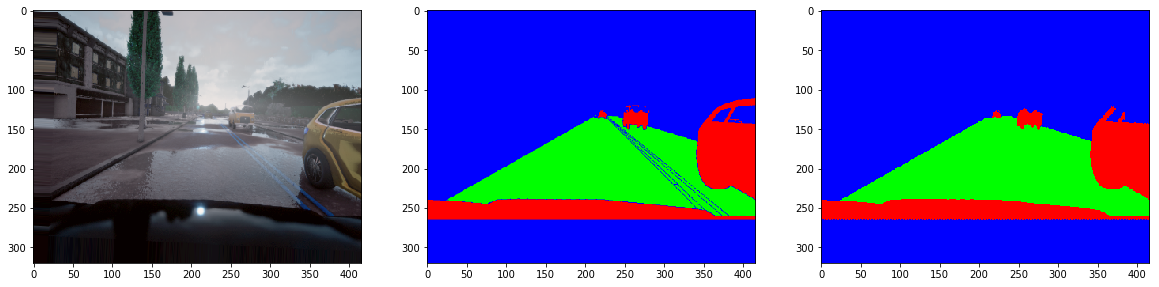

In [9]:
pred = model.predict(X)
pred = pred[0].argmax(axis=2)
pred_out = np.zeros_like(Y[0])
pred_out[:, :, 0] = pred == 0
pred_out[:, :, 1] = pred == 1
pred_out[:, :, 2] = pred == 2

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(np.clip(X[0]+110, 0, 255).astype(np.uint8))
plt.subplot(132)
plt.imshow(Y[0])
plt.subplot(133)
plt.imshow(pred_out)

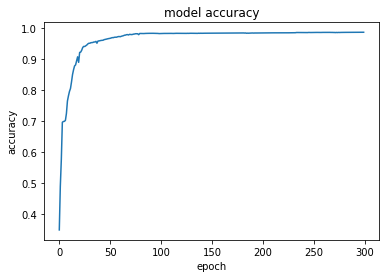

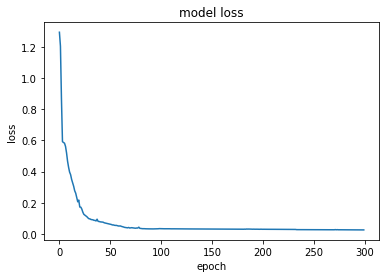

In [10]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()